# Consistent scores

A "consistent scoring function" is a scoring function where a forecaster's expected score will be optimised by following a forecast directive. An example of a forecast directive is to "predict the mean (i.e., expected) rainfall amount". Using a consistent scoring function ensures that a forecaster or forecast system developer isn't faced with the dilemma of whether to 

1. produce forecasts (or develop a forecast system) that optimises the expected verification score, or
2. produce an honest forecast (or develop an honest forecast system) that is optimal for the forecast directive. 

Using a consistent scoring function to evaluate forecast performance ensures that objectives both 1 and 2 can be met without any tensions. For example, the Mean Squared Error (MSE) is a consistent score for forecasting the mean (i.e., expected) rainfall amount, since forecasting the "mean rainfall amount" will minimise the expected MSE. However the Mean Absolute Error (MAE) is not consistent with forecasting the mean value and is instead consistent with forecasting the median value. Consistent scoring functions are formally defined in ([Gneiting et al., 2011a](https://www.tandfonline.com/doi/abs/10.1198/jasa.2011.r10138)).


You may already know that the MSE is a consistent score for forecasting the mean and the MAE is a consistent score for forecasting the median. But did you know that there are a whole family of scores that are consistent for predicting the mean, median, or quantiles? 

The consistent scoring module in `scores` provides access to these families of consistent scores that can be used to tailor emphasis of predictive performance based on decision thresholds of interest.

<div class="alert alert-block alert-success">
<b>Note:</b> Threshold weighted scoring functions will be added to scores. These threshold weighted scoring functions will use these consistent scoring functions and will allow users a more simplified approach to evaluating forecasts using scores that emphasise performance across different decision thresholds. Its tutorial notebook is expected to compliment this.
</div>

### Example 1. A score consistent with the mean
Let's jump into an example that illustrates a scoring function that is consistent with predicting the mean value using `scores`. Suppose we want to evaluate the performance of expected daily precipitation forecasts, but we want to place increasing importance on correctly forecasting extreme values. MSE is consistent with predicting the mean value, but weights all decision thresholds equally (as discussed further on).

The mean (or expectation) functional is equivalent to the 0.5-[expectile](https://en.wikipedia.org/wiki/Expectile), so we want to use the `consistent_expectile_score` in `scores` to evaluate the expected daily precipitation forecasts. Note that the mean is identical to the 0.5-expectile in the same way that the median is identical to the 0.5-quantile (or 50th percentile).

A scoring function $S$ that is consistent for the alpha-expectile takes the following form ([Savage 1971](https://doi.org/10.2307/2284229)):

 $$ S(x, y) =
    \begin{cases}
    (1 - \alpha)(\phi(y) - \phi(x) - \phi'(x)(y-x)), & y < x \\
    \alpha(\phi(y) - \phi(x) - \phi'(x)(y-x)), & x \leq y
    \end{cases}
$$

Where:
- $x$ is the forecast
- $y$ is the observation
- $\alpha$ is the expectile level
- $\phi$ is a [convex function](https://en.wikipedia.org/wiki/Convex_function) of a single variable
- $\phi'$ is the [subderivative](https://en.wikipedia.org/wiki/Subderivative) of $\phi$. The subderivative is a generalisation of the derivative for convex functions and coincides with the derivative when the convex function is differentiable
- $S(x,y)$ is the score.

In this case, we choose $\alpha=0.5$, since the 0.5-expectile is identical to the mean.

If one wants to control the relative importance of predictive performance across different decision thresholds, they must first create a weighting function $\phi''$ which is the second derivative of $\phi$.

Let's assume that the importance of accurate prediction increases exponentially with increasing decision threshold $z$. We then need to determine our $\phi(z)$ and $\phi'(z)$ functions. 

First we create the weighting function

$$\phi''(z) = e^\frac{z}{10}$$ 

This will place increasing importance on more extreme rainfall thresholds. We will plot this weighting function further below.

Next we need to integrate $\phi''(z)$ twice so that we can obtain the functions for our consistent scoring function

$$\phi'(z) = 10e^\frac{z}{10}$$ 
and 
$$\phi(z) = 100e^\frac{z}{10}$$ 

These equations with $\alpha=0.5$ can be substituted into $S(x, y)$ to create our consistent scoring function

$$
S(x,y) = \frac{1}{2}(100e^\frac{y}{10} - 110e^\frac{x}{10})(y-x)
$$

Note that to use the `consistent_expectile_score` in scores, you only need to define $\phi(z)$ and $\phi'(z)$, but not $S(x, y)$.

Also note that the squared loss (used in MSE) can be created with $\phi(z)=2z^2$ with $\alpha=0.5$. We leave this as an exercise for the reader to show that $S(x,y)=(x-y)^2$ when $\phi(z)=2z^2$ and $\alpha=0.5$.

Let's illustrate how this can be done in scores using some synthetic rainfall data.

In [1]:
from scores.continuous import consistent_expectile_score, consistent_quantile_score, mse, murphy_score, murphy_thetas
import matplotlib.pyplot as plt
from scipy.stats import skewnorm
import numpy as np
import xarray as xr

np.random.seed(100)

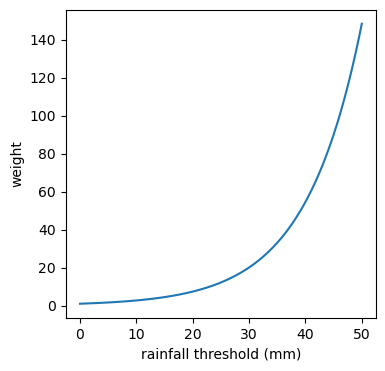

In [2]:
# First, let's visualise our weighting function phi''
# Higher weights mean that there is a higher importance place on forecasting values around
# those decision thresholds in the scoring function
x = np.linspace(0, 50, 1000)
y = np.exp(x / 10)

plt.figure(figsize=(4, 4))
plt.plot(x, y)
plt.xlabel("rainfall threshold (mm)")
plt.ylabel("weight")
plt.show()

In [3]:
# define phi and phi prime
def phi_prime(z):
    """Phi prime"""
    return 10 * np.exp(z / 10)


def phi(z):
    """Phi"""
    return 100 * np.exp(z / 10)

In [4]:
# Generate some synthetic rainfall observations between 0 and 50mm
N = 1000
obs = xr.DataArray(data=50 * np.random.random(N), dims=["time"], coords={"time": np.arange(0, N)})
obs = obs.clip(min=0)  # don't allow negative rainfall

# Generate synthetic forecasts by adding noise to each observation
fcst1 = 0.9 * obs + skewnorm.rvs(4, size=N)  # fcst1 has a low bias
fcst1 = fcst1.clip(min=0)  # don't allow negative rainfall
fcst2 = 1.1 * obs - skewnorm.rvs(4, size=N)  # fcst2 has a high bias
fcst2 = fcst2.clip(min=0)  # don't allow negative rainfall

In [5]:
# First if we calculate the MSE of fcst1 and fcst2 we will see that that have similar predictive performance.
print(f"fcst1 MSE = {mse(fcst1, obs).item()}")
print(f"fcst2 MSE = {mse(fcst2, obs).item()}")

fcst1 MSE = 5.397562928167134
fcst2 MSE = 5.3763094346565685


In [6]:
# However, when we calculate the performance of these forecasts with increasing focus on
# extreme decision thresholds, we see that the performance is quite different.
fcst1_cons_score = consistent_expectile_score(fcst1, obs, alpha=0.5, phi=phi, phi_prime=phi_prime).item()
fcst2_cons_score = consistent_expectile_score(fcst2, obs, alpha=0.5, phi=phi, phi_prime=phi_prime).item()

print(f"fcst1 consistent score = {fcst1_cons_score}")
print(f"fcst2 consistent score = {fcst2_cons_score}")

fcst1 consistent score = 67.77792339205789
fcst2 consistent score = 114.52858223319328


Why is this? To visualise the difference in performance, we use plot Murphy Diagrams. See the [Murphy Diagrams tutorial](./Murphy_Diagrams.ipynb).

Text(0.5, 0.98, 'Murphy Score (for mean)')

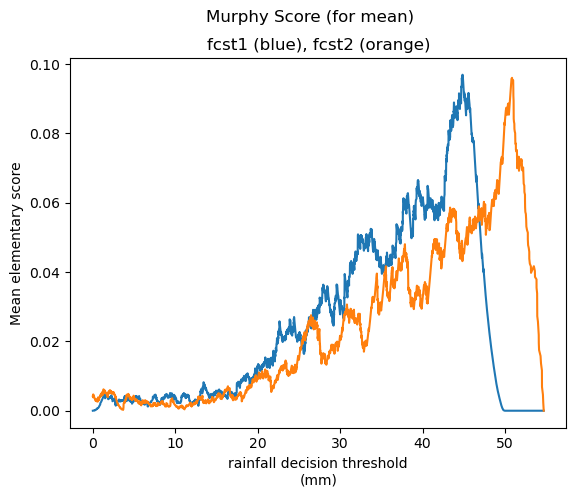

In [7]:
# Generate a list of thresholds of interest
thetas = murphy_thetas([fcst1, fcst2], obs, "expectile")

# Calculate the average elementary score for the mean (0.5 expectile) for each threshold theta
ms1 = murphy_score(fcst1, obs, thetas, functional="expectile", alpha=0.5)
ms2 = murphy_score(fcst2, obs, thetas, functional="expectile", alpha=0.5)

# Rename date variable for plotting
ms1 = ms1.rename({"total": "Mean elementary score", "theta": "rainfall decision threshold (mm)"})
ms2 = ms2.rename({"total": "Mean elementary score", "theta": "rainfall decision threshold (mm)"})

# Plot the results
ms1["Mean elementary score"].plot()
ms2["Mean elementary score"].plot()
plt.title("fcst1 (blue), fcst2 (orange)")
plt.suptitle("Murphy Score (for mean)")

Lower values are better on the Murphy Diagram. Fcst2 (orange) performs far worse at higher rainfall thresholds, so is penalised more heavily due to out weighting function $\phi''(z) = \exp ^\frac{z}{10}$.

### Example 2. A score consistent with a quantile

Suppose we have a 90th percentile wind speed forecast that we want to evaluate. Additionally, we wish to emphasise predictive performance for higher decision thresholds. We can use the `consistent_quantile_score` in `scores`.

Every consistent score for an alpha-quantile has the form $S$ ([Gneiting 2011b](https://doi.org/10.1016/j.ijforecast.2009.12.015)), where

$$ S(x, y) = \begin{cases}(1 - \alpha)(g(x) - g(y)), & y < x \\\alpha(g(y) - g(x)), & x \leq y\end{cases}$$

where:

- $x$ is the forecast
- $y$ is the observation
- $\alpha$ is the quantile level
- $g$ is a nondecreasing function of a single variable
- $S(x,y)$ is the score.


Similar to how $\phi''$ was our weighting function in the first example, in this case $g'$ is our weighting function.

Now suppose we want to emphasise the performance for higher thresholds, but we don't want our weights to increase exponentially like in rainfall example above. We first define our weighting function as 

$$g'(z)= \frac{-1}{(z+10)}+0.5$$

Let's visualise our weighting function

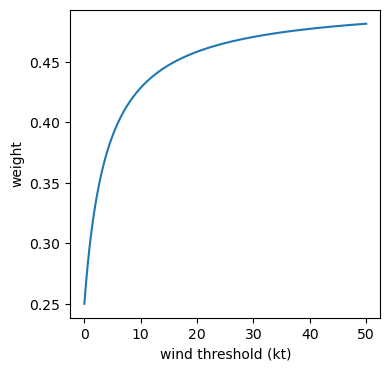

In [8]:
x = np.linspace(0, 50, 1000)
y = -1 / (x + 4) + 0.5

plt.figure(figsize=(4, 4))
plt.plot(x, y)
plt.xlabel("wind threshold (kt)")
plt.ylabel("weight")
plt.show()

We need to obtain $g$ for our `consistent_quantile_score` by integrating $g'$

$$g(z) = 0.5z - ln(z+4)$$

To evaluate the 90th percentile forecast, we need to set $\alpha=0.9$. Now we can use the `consistent_quantile_score`.

Note that taking $\alpha=0.5$ and $g(z)=2z$ recovers the absolute loss. Since $g'(z)$ is a constant, MAE can be interpreted as having equal weights for all decision thresholds.

In [9]:
def g(z):
    """g(z) for our conistent score"""
    return 0.5 * z - np.log(z + 4)

In [10]:
# Let's assume that the synthetic rainfall data that we created before is now synthetic
# wind speed data
fcst1_cons_quant_score = consistent_quantile_score(fcst1, obs, alpha=0.9, g=g).item()
fcst2_cons_quant_score = consistent_quantile_score(fcst2, obs, alpha=0.9, g=g).item()

print(f"fcst1 consistent quantile score = {fcst1_cons_quant_score}")
print(f"fcst2 consistent quantile score = {fcst2_cons_quant_score}")

fcst1 consistent quantile score = 0.7710748324858289
fcst2 consistent quantile score = 0.12031432648877705


In this case, fcst2 performs better. This is because it has an overforecast bias for a mean forecast, but it performs better than fcst1 as a 90th percentile forecast. Let's visualise this on a Murphy Diagram that shows the performance for 90th percentile forecasts across each decision threshold.

Text(0.5, 0.98, 'Murphy Score (for 90th percentile)')

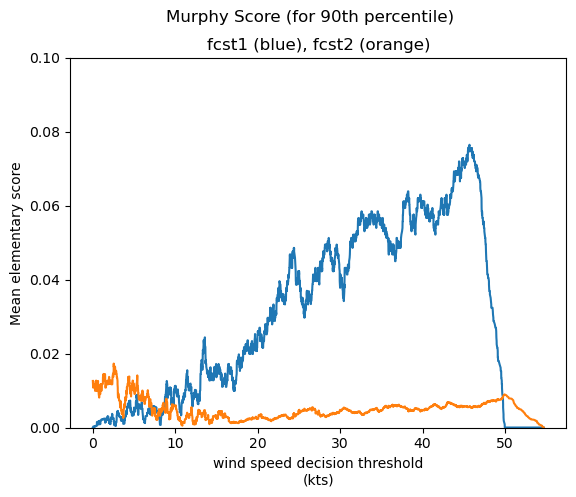

In [11]:
# Generate a list of thresholds of interest
thetas = murphy_thetas([fcst1, fcst2], obs, "quantile")

ms1 = murphy_score(fcst1, obs, thetas, functional="quantile", alpha=0.9)
ms2 = murphy_score(fcst2, obs, thetas, functional="quantile", alpha=0.9)

# Rename date variable for plotting
ms1 = ms1.rename({"total": "Mean elementary score", "theta": "wind speed decision threshold (kts)"})
ms2 = ms2.rename({"total": "Mean elementary score", "theta": "wind speed decision threshold (kts)"})

# Plot the results
ms1["Mean elementary score"].plot()
ms2["Mean elementary score"].plot()
plt.ylim(0, 0.1)
plt.title("fcst1 (blue), fcst2 (orange)")
plt.suptitle("Murphy Score (for 90th percentile)")

What we can see is that fcst2 (orange) performs best for most decision thresholds. Despite weighting higher wind speed thresholds more heavily and fcst2 performing worse for thresholds above 50kt, fcst2 still scored better because it performed substantially better for many decision thresholds and the weights did not exponentially increase.

## Things to try next.

- Test out different weighting functions. 
- Try out `consistent_huber_score`. This uses $\phi$ and $\phi'$ like `consistent_expectile_score`, but also takes a huber parameter.

## Further reading
- [Gneiting, T., 2011. Making and evaluating point forecasts. Journal of the American Statistical Association, 106(494), pp.746-762.](https://doi.org/10.1198/jasa.2011.r10138)
- [Gneiting, T. (2011). Quantiles as optimal point forecasts. International Journal of Forecasting, 27(2), 197–207.](https://doi.org/10.1016/j.ijforecast.2009.12.015)
- [Savage, L. J. (1971). Elicitation of Personal Probabilities and Expectations. Journal of the American Statistical Association, 66(336), 783.](https://doi.org/10.2307/2284229)
- [Taggart, R., 2022. Evaluation of point forecasts for extreme events using consistent scoring functions. Quarterly Journal of the Royal Meteorological Society, 148(742), pp.306-320.](https://doi.org/10.1002/qj.4206)
- [Taggart, R.J., 2022. Point forecasting and forecast evaluation with generalized Huber loss. Electronic Journal of Statistics, 16(1), pp.201-231.](https://doi.org/10.1214/21-EJS1957)